In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
df = pd.read_csv('/Users/shahadaleissa/hyper_code/Dataset/cleaned_hypertension_data.csv')
X=df.drop('Class',axis=1)
y=df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

xgboost_clf=xgb.XGBClassifier(eta=0.21000000000000002)
HGB_clf = HistGradientBoostingClassifier()
ada_clf = AdaBoostClassifier()
svm_clf = SVC(probability=True)
rf_clf = RandomForestClassifier(random_state=42)

### first method: voting classifier

In [33]:
voting_clf = VotingClassifier(
    estimators=[('xgb', xgboost_clf), ('hgb', HGB_clf), ('ada', ada_clf), ('svm', svm_clf), ('rf', rf_clf)],
    voting='soft')

In [34]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eta=0.21000000000000002,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_cons...
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None, ...)),
                             ('hgb', HistGradientBoostingClassifier()),
                             ('ada', AdaBoostClassifier()),
                             ('svm', SVC(probability=True)),
                             ('rf', RandomForestClassifier(random_state=42))],
                 voting='soft')

In [35]:
from sklearn.metrics import accuracy_score
for clf in (xgboost_clf,HGB_clf,ada_clf,rf_clf,svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

XGBClassifier 0.9275
HistGradientBoostingClassifier 0.9125
AdaBoostClassifier 0.8725
RandomForestClassifier 0.9125
SVC 0.875
VotingClassifier 0.91


### second method: Averaging

In [44]:
xgboost_clf.fit(X_train, y_train)
ada_clf.fit(X_train, y_train)
HGB_clf.fit(X_train, y_train)
svm_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)

pred1 = xgboost_clf.predict(X_test)
pred2 = ada_clf.predict(X_test)
pred3 = HGB_clf.predict(X_test)
pred4 = svm_clf.predict(X_test)
pred5 = rf_clf.predict(X_test)

final_pred = (pred1 + pred2 + pred3 + pred4 + pred5) / 5.0

In [45]:
accuracy_score(y_test, final_pred.round())

0.9125

### third method: weighted averaging

In [46]:
xgboost_clf.fit(X_train, y_train)
ada_clf.fit(X_train, y_train)
HGB_clf.fit(X_train, y_train)
svm_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)

pred1 = xgboost_clf.predict(X_test)
pred2 = ada_clf.predict(X_test)
pred3 = HGB_clf.predict(X_test)
pred4 = svm_clf.predict(X_test)
pred5 = rf_clf.predict(X_test)

final_pred = (pred1*0.4 + pred2*0.1 + pred3*0.2 + pred4*0.2 + pred5*0.1)

In [47]:
accuracy_score(y_test, final_pred.round())

0.9175

### fourth method: stacking

In [14]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression


xgboost_clf=xgb.XGBClassifier(eta=0.21000000000000002)
HGB_clf = HistGradientBoostingClassifier()
ada_clf = AdaBoostClassifier()
svm_clf = SVC(probability=True)
rf_clf = RandomForestClassifier(random_state=42)

def get_models():
 models = dict()
 models['xgboost'] = xgboost_clf
 models['HGB'] = HGB_clf
 models['ada'] = ada_clf
 models['svm'] = svm_clf
 models['rf'] = rf_clf
 
 return models


In [8]:
# evaluate a given model using cross-validation
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score


def evaluate_model(model, X, y):
 cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
 scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
 return scores

>xgboost 0.892 (0.028)
>HGB 0.892 (0.025)
>ada 0.875 (0.024)
>svm 0.518 (0.029)
>rf 0.888 (0.024)


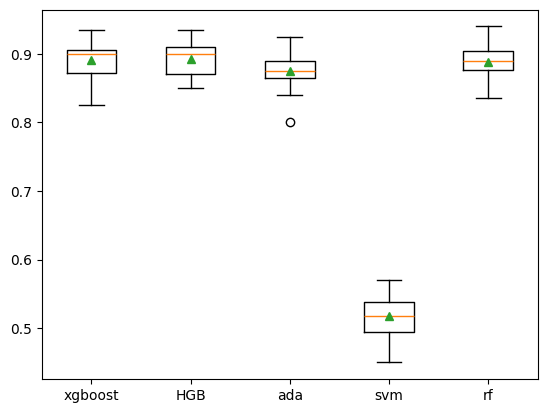

In [13]:
from matplotlib import pyplot
from numpy import mean, std

results, names = list(), list()
# get the models to evaluate
models = get_models()
for name, model in models.items():
 scores = evaluate_model(model, X, y)
 results.append(scores)
 names.append(name)
 print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [17]:
stacking= StackingClassifier(estimators=[('xgb', xgboost_clf), ('hgb', HGB_clf), ('ada', ada_clf), ('svm', svm_clf), ('rf', rf_clf)],final_estimator=LogisticRegression(), cv=5)
stacking.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eta=0.21000000000000002,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interacti...
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None, ...)),
                               ('hgb', HistGradientBoostingClassifier()),
                               ('ada', AdaBoostClassifier()),
                               ('svm', SVC(probability=True)),
                               ('rf', RandomForestClassifier(random_state=42))],
                   final_estimator=LogisticRegression())

In [18]:
accuracy_score(y_test, stacking.predict(X_test))

0.9125